In [3]:
import operator
import numpy as np
import pandas as pd
import pickle as pk
import xgboost as xg
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as ms

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


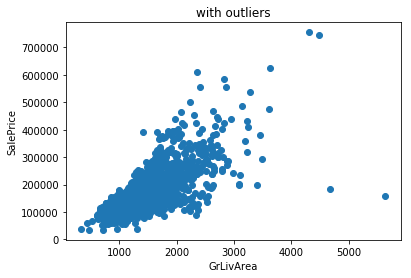

In [7]:
# removing outliers

plt.plot(train['GrLivArea'], train['SalePrice'], 'o')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title("with outliers")
plt.show()

In [8]:
train[train['GrLivArea']>4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [9]:
train = train[train['GrLivArea']<4000]

In [10]:
train.shape

(1456, 81)

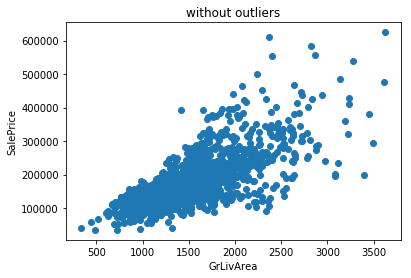

In [11]:
plt.plot(train['GrLivArea'], train['SalePrice'], 'o')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title("without outliers")
plt.show()

In [12]:
def dict_nan():
    
    col_nan = dict()

    for i in train.columns:
        col_nan[i] = len(train[i])-train[i].count()

    for i in test.columns: 
        col_nan[i] += len(test[i])-test[i].count()
        
    return col_nan


def plot_nan():

    col_nan = dict_nan()
    
    plt.bar(col_nan.keys(), col_nan.values())
    plt.xlabel('feature')
    plt.ylabel('no of nan values')
    plt.title("nan values")
    plt.show()
    
    
def desired_col(thresh):
    
    col_nan = dict_nan()
    col_to_drop = []

    for feature in col_nan.keys():
        if col_nan[feature] > thresh:
            col_to_drop.append(feature)
            
    return col_to_drop  


def random_choice(length, choices):
    
    random_list = {}
    for i in range(train.shape[0]):
        random_list[i] = np.random.choice(choices)
    return random_list


def fill_col(name, val):
    
    train[name].fillna(val, inplace=True)
    test[name].fillna(val, inplace=True)


def fill_col_random(name, val):
    
    random_list = random_choice(train.shape[0], val)
    train[name].fillna(random_list, inplace=True)
    random_list = random_choice(test.shape[0], val)
    test[name].fillna(random_list, inplace=True)
    train[name].value_counts().head(10)
    
    
def drop(name):
    
    train.drop(name, axis=1, inplace=True)
    test.drop(name, axis=1, inplace=True)

    
flag = []    

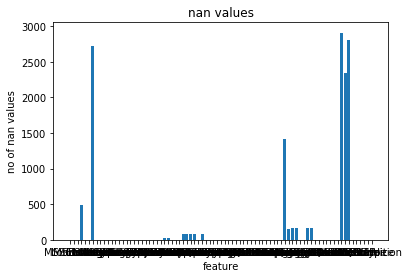

In [13]:
plot_nan()

In [14]:
col = desired_col(400)
col

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [15]:
# removing above listed columns

train.drop(col, axis=1, inplace=True)
test.drop(col, axis=1, inplace=True)

In [16]:
train.shape, test.shape

((1456, 75), (1459, 74))

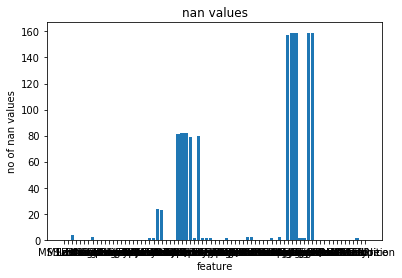

In [17]:
plot_nan()    

In [18]:
desired_col(100)

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

In [19]:
train['GarageCond'].value_counts()

TA    1322
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [20]:
fill_col('GarageCond', 'TA')
train['GarageCond'].value_counts()

TA    1403
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [21]:
train['GarageQual'].value_counts()

TA    1307
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [22]:
fill_col('GarageQual', 'TA')
train['GarageQual'].value_counts()

TA    1388
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [23]:
desired_col(100)

['GarageType', 'GarageYrBlt', 'GarageFinish']

In [24]:
train['GarageType'].value_counts()

Attchd     867
Detchd     387
BuiltIn     87
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [25]:
fill_col('GarageType', 'Attchd')
train['GarageType'].value_counts()

Attchd     948
Detchd     387
BuiltIn     87
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [26]:
train['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    348
Name: GarageFinish, dtype: int64

In [27]:
fill_col('GarageFinish', 'Unf')
train['GarageFinish'].value_counts()

Unf    686
RFn    422
Fin    348
Name: GarageFinish, dtype: int64

In [28]:
train['GarageYrBlt'].value_counts().head(10)  # most garages are built in 2003, 4, 5, 6, 7

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    48
1977.0    35
1998.0    31
1999.0    30
1976.0    29
2008.0    28
Name: GarageYrBlt, dtype: int64

In [29]:
fill_col_random('GarageYrBlt', [2003, 2004, 2005, 2006, 2007])
train['GarageYrBlt'].value_counts().head(10)

2005.0    80
2006.0    75
2004.0    72
2003.0    66
2007.0    63
1977.0    35
1998.0    31
1999.0    30
1976.0    29
2008.0    28
Name: GarageYrBlt, dtype: int64

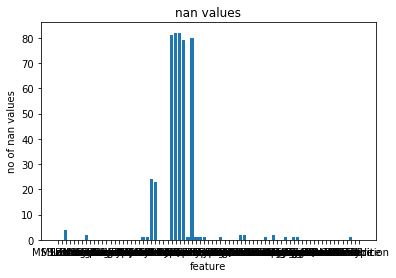

In [30]:
plot_nan()

In [31]:
desired_col(40)

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

In [32]:
train['BsmtQual'].value_counts().head(10)

TA    649
Gd    618
Ex    117
Fa     35
Name: BsmtQual, dtype: int64

In [33]:
fill_col_random('BsmtQual', ['TA', 'Gd'])
train['BsmtQual'].value_counts().head(10)

TA    666
Gd    638
Ex    117
Fa     35
Name: BsmtQual, dtype: int64

In [34]:
desired_col(40)

['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

In [35]:
train['BsmtCond'].value_counts()

TA    1307
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [36]:
fill_col('BsmtCond', 'TA')
train['BsmtCond'].value_counts()

TA    1344
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [37]:
train['BsmtExposure'].value_counts()

No    953
Av    220
Gd    131
Mn    114
Name: BsmtExposure, dtype: int64

In [38]:
fill_col('BsmtExposure', 'No')
train['BsmtExposure'].value_counts()

No    991
Av    220
Gd    131
Mn    114
Name: BsmtExposure, dtype: int64

In [39]:
train['BsmtFinType1'].value_counts()

Unf    430
GLQ    414
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [40]:
fill_col_random('BsmtFinType1', ['Unf', 'GLQ'])
train['BsmtFinType1'].value_counts().head(10)

Unf    444
GLQ    437
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [41]:
train['BsmtFinType2'].value_counts()

Unf    1252
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [42]:
fill_col('BsmtFinType2', 'Unf')
train['BsmtFinType2'].value_counts()

Unf    1290
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

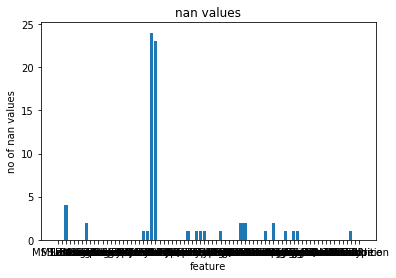

In [43]:
plot_nan()

In [44]:
desired_col(20)

['MasVnrType', 'MasVnrArea']

In [45]:
train['MasVnrType'].value_counts()

None       863
BrkFace    444
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

In [46]:
fill_col('MasVnrType', 'None')
train['MasVnrType'].value_counts()

None       871
BrkFace    444
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

In [47]:
train['MasVnrArea'].value_counts().head(5)

0.0      860
72.0       8
180.0      8
108.0      8
120.0      7
Name: MasVnrArea, dtype: int64

In [48]:
fill_col('MasVnrArea', 0.0)
train['MasVnrArea'].value_counts().head(5)

0.0      868
72.0       8
180.0      8
108.0      8
120.0      7
Name: MasVnrArea, dtype: int64

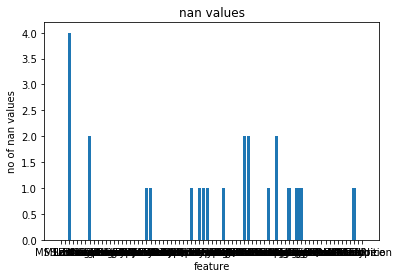

In [49]:
plot_nan()

In [50]:
desired_col(1)

['MSZoning', 'Utilities', 'BsmtFullBath', 'BsmtHalfBath', 'Functional']

In [51]:
train['MSZoning'].value_counts()

RL         1147
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [52]:
fill_col('MSZoning', 'RL')
train['MSZoning'].value_counts()

RL         1147
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [53]:
test['Utilities'].value_counts()    # no use of this feature, only one value in test dataset

AllPub    1457
Name: Utilities, dtype: int64

In [54]:
train.drop(['Utilities'], axis=1, inplace=True)
test.drop(['Utilities'], axis=1, inplace=True)
train.shape, test.shape

((1456, 74), (1459, 73))

In [55]:
train['BsmtFullBath'].value_counts()

0    855
1    586
2     14
3      1
Name: BsmtFullBath, dtype: int64

In [56]:
fill_col('BsmtFullBath', 0)
train['BsmtFullBath'].value_counts()

0    855
1    586
2     14
3      1
Name: BsmtFullBath, dtype: int64

In [57]:
train['BsmtHalfBath'].value_counts()

0    1375
1      79
2       2
Name: BsmtHalfBath, dtype: int64

In [58]:
fill_col('BsmtHalfBath', 0)
train['BsmtHalfBath'].value_counts()

0    1375
1      79
2       2
Name: BsmtHalfBath, dtype: int64

In [59]:
train['Functional'].value_counts()

Typ     1356
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [60]:
fill_col('Functional', 'Typ')
train['Functional'].value_counts()

Typ     1356
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

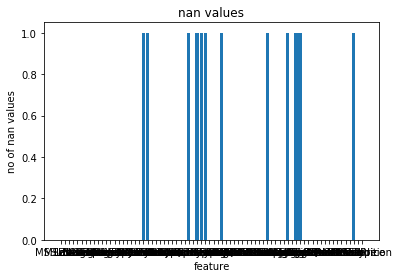

In [61]:
plot_nan()

In [62]:
desired_col(.5)

['Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'KitchenQual',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [63]:
train['Exterior1st'].value_counts().head(5)

VinylSd    515
HdBoard    221
MetalSd    220
Wd Sdng    205
Plywood    108
Name: Exterior1st, dtype: int64

In [64]:
fill_col('Exterior1st', 'VinylSd')
fill_col('Exterior2nd', 'VinylSd')

In [65]:
train['BsmtFinSF1'].value_counts().head(5)

0      467
24      12
16       9
20       5
936      5
Name: BsmtFinSF1, dtype: int64

In [66]:
fill_col('BsmtFinSF1', 0)
fill_col('BsmtFinSF2', 0)
fill_col('BsmtUnfSF', 0)
fill_col('TotalBsmtSF', 0)

In [67]:
train['Electrical'].value_counts().head(5)

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [68]:
fill_col('Electrical', 'SBrkr')

In [69]:
train['KitchenQual'].value_counts().head(5)

TA    735
Gd    586
Ex     96
Fa     39
Name: KitchenQual, dtype: int64

In [70]:
fill_col('KitchenQual', 'TA')

In [71]:
train['GarageYrBlt'].value_counts().head(5)

2005.0    80
2006.0    75
2004.0    72
2003.0    66
2007.0    63
Name: GarageYrBlt, dtype: int64

In [72]:
fill_col('GarageYrBlt', 2005)

In [73]:
train['GarageCars'].value_counts().head(5)

2    823
1    369
3    178
0     81
4      5
Name: GarageCars, dtype: int64

In [74]:
fill_col('GarageCars', 2)

In [75]:
train['GarageArea'].value_counts().head(5)

0      81
440    49
576    47
240    38
484    34
Name: GarageArea, dtype: int64

In [76]:
fill_col('GarageArea', 0)

In [77]:
train['SaleType'].value_counts().head(5)

WD       1265
New       120
COD        43
ConLD       9
ConLw       5
Name: SaleType, dtype: int64

In [78]:
fill_col('SaleType', 'WD')

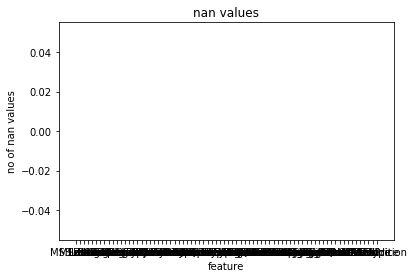

all nan values cleared


In [79]:
plot_nan()
print("all nan values cleared")

In [80]:
corr = train.corr()
corr

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011076,-0.038041,-0.032323,0.013337,-0.014034,-0.023076,-0.053851,-0.017821,-0.005609,...,-0.030644,-0.002471,0.003348,-0.046540,0.001674,0.040871,-0.006138,0.023245,0.000793,-0.027455
MSSubClass,0.011076,1.000000,-0.142192,0.032416,-0.059277,0.027689,0.040459,0.023441,-0.075268,-0.065598,...,-0.012853,-0.006687,-0.011966,-0.043802,-0.025979,0.007957,-0.007666,-0.013512,-0.021330,-0.088160
LotArea,-0.038041,-0.142192,1.000000,0.088719,-0.002832,0.006590,0.006930,0.080357,0.173426,0.114691,...,0.167040,0.061679,-0.016108,0.021505,0.045620,0.033875,0.039192,0.007188,-0.013014,0.269866
OverallQual,-0.032323,0.032416,0.088719,1.000000,-0.090692,0.571712,0.550971,0.395336,0.213079,-0.057520,...,0.232819,0.297803,-0.112407,0.031621,0.067732,0.018121,-0.031068,0.076414,-0.024321,0.800858
OverallCond,0.013337,-0.059277,-0.002832,-0.090692,1.000000,-0.375691,0.074703,-0.127621,-0.042542,0.040015,...,-0.003063,-0.029649,0.070103,0.025419,0.054617,0.008079,0.068729,-0.003135,0.043755,-0.080202
YearBuilt,-0.014034,0.027689,0.006590,0.571712,-0.375691,1.000000,0.591906,0.309923,0.248272,-0.048393,...,0.222690,0.183905,-0.386904,0.031717,-0.049703,-0.014373,-0.034193,0.013881,-0.012593,0.535279
YearRemodAdd,-0.023076,0.040459,0.006930,0.550971,0.074703,0.591906,1.000000,0.172959,0.121690,-0.067188,...,0.204020,0.222649,-0.193348,0.045596,-0.038176,-0.009490,-0.010100,0.022629,0.036597,0.521428
MasVnrArea,-0.053851,0.023441,0.080357,0.395336,-0.127621,0.309923,0.172959,1.000000,0.231890,-0.070339,...,0.149790,0.102935,-0.109156,0.020620,0.066081,-0.015826,-0.029385,0.003207,-0.005003,0.473650
BsmtFinSF1,-0.017821,-0.075268,0.173426,0.213079,-0.042542,0.248272,0.121690,0.231890,1.000000,-0.048738,...,0.201462,0.071851,-0.103053,0.029879,0.070026,0.016380,0.005149,-0.001773,0.018506,0.395923
BsmtFinSF2,-0.005609,-0.065598,0.114691,-0.057520,0.040015,-0.048393,-0.067188,-0.070339,-0.048738,1.000000,...,0.069028,0.005083,0.036269,-0.030090,0.088676,0.053178,0.004871,-0.015726,0.031384,-0.008900


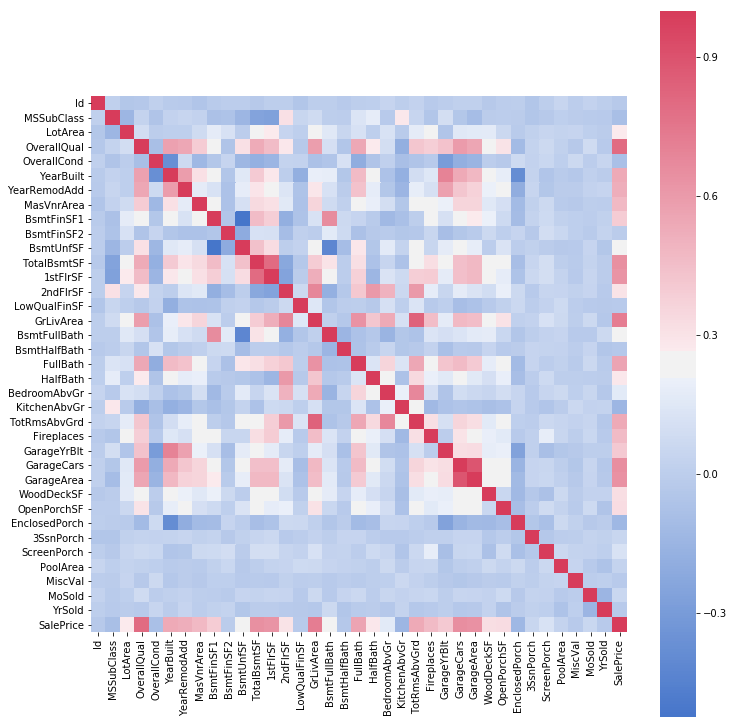

In [81]:
f, ax = plt.subplots(figsize=(12, 13))
sb.heatmap(corr, cmap=sb.diverging_palette(255, 5, as_cmap=True), square=True, ax=ax)

In [82]:
corr_features = corr['SalePrice'][corr['SalePrice']>0.5]
corr_features

OverallQual     0.800858
YearBuilt       0.535279
YearRemodAdd    0.521428
TotalBsmtSF     0.646584
1stFlrSF        0.625235
GrLivArea       0.720516
FullBath        0.559048
TotRmsAbvGrd    0.537462
GarageCars      0.649256
GarageArea      0.636964
SalePrice       1.000000
Name: SalePrice, dtype: float64

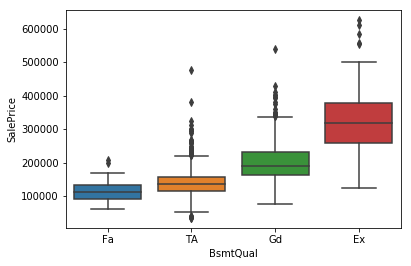

In [83]:
# analyzing basement effects

sb.boxplot(train['BsmtQual'], train['SalePrice'], order=['Fa', 'TA', 'Gd', 'Ex'])

In [84]:
train['BsmtQual'].value_counts()    # we should convert these to ordinal features

TA    666
Gd    638
Ex    117
Fa     35
Name: BsmtQual, dtype: int64

In [85]:
train['BsmtQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4], inplace=True)
test['BsmtQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4], inplace=True)
train['BsmtQual'].value_counts()

2    666
3    638
4    117
1     35
Name: BsmtQual, dtype: int64

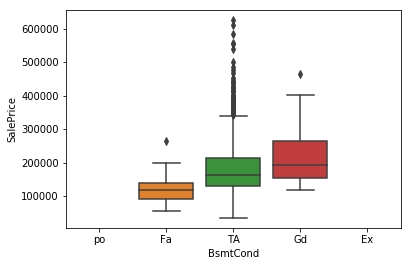

In [86]:
sb.boxplot(train['BsmtCond'], train['SalePrice'], order=['po', 'Fa', 'TA', 'Gd', 'Ex'])

In [87]:
train['BsmtCond'].value_counts()     # here we see that some TA basements are very high sold.

TA    1344
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [88]:
train['BsmtCond'].replace(['Po', 'Fa', 'TA', 'Gd'],[1,2,3,4], inplace=True)
test['BsmtCond'].replace(['Po', 'Fa', 'TA', 'Gd'],[1,2,3,4], inplace=True)
train['BsmtCond'].value_counts()

3    1344
4      65
2      45
1       2
Name: BsmtCond, dtype: int64

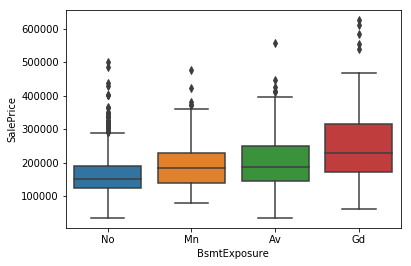

In [89]:
sb.boxplot(train['BsmtExposure'], train['SalePrice'], order=['No', 'Mn', 'Av', 'Gd'])

In [90]:
train['BsmtExposure'].value_counts()

No    991
Av    220
Gd    131
Mn    114
Name: BsmtExposure, dtype: int64

In [91]:
train['BsmtExposure'].replace(['No', 'Mn', 'Av', 'Gd'],[1,2,3,4], inplace=True)
test['BsmtExposure'].replace(['No', 'Mn', 'Av', 'Gd'],[1,2,3,4], inplace=True)
train['BsmtExposure'].value_counts()

1    991
3    220
4    131
2    114
Name: BsmtExposure, dtype: int64

In [92]:
def scatter_plot(name):
    
    plt.plot(train[name], train['SalePrice'], 'o')
    plt.xlabel(name)
    plt.ylabel('saleprice')
    plt.show()
    
def make_dummies(name):
    
    global train, test
    train = pd.get_dummies(train, columns = [name])
    test = pd.get_dummies(test, columns = [name])  
    
def create_bins(name, bins):
    
    if type(bins) == list:
        ran = len(bins)-1
    else:
        ran = bins
    global train, test
    train[name] = pd.cut(train[name], bins, labels=[name+'_'+str(i) for i in range(ran)])
    test[name] = pd.cut(test[name], bins, labels=[name+'_'+str(i) for i in range(ran)])
    make_dummies(name)    

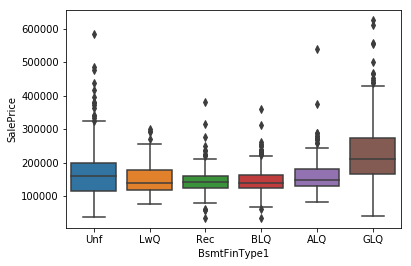

In [93]:
sb.boxplot(train['BsmtFinType1'], train['SalePrice'], order=['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

In [94]:
# this features is not behaving like ordinal

make_dummies('BsmtFinType1')
train.shape, test.shape

((1456, 79), (1459, 78))

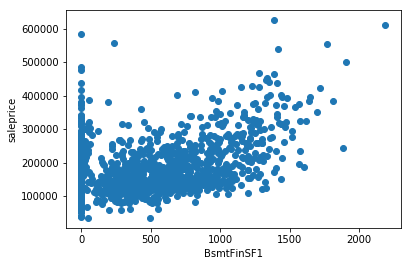

In [95]:
scatter_plot('BsmtFinSF1')

In [96]:
create_bins('BsmtFinSF1', 4)
train.shape, test.shape

((1456, 82), (1459, 81))

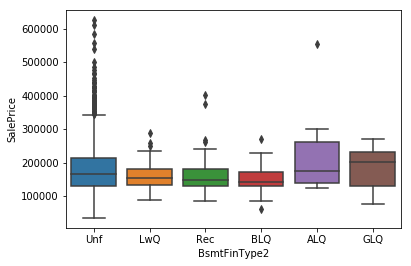

In [97]:
sb.boxplot(train['BsmtFinType2'], train['SalePrice'], order=['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

In [98]:
# also does not seem like ordinal variable

make_dummies('BsmtFinType2')
train.shape, test.shape

((1456, 87), (1459, 86))

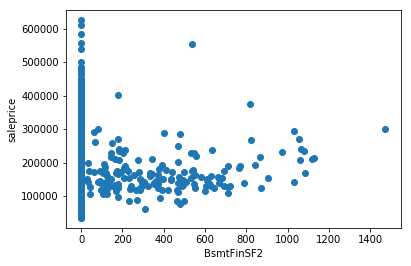

In [99]:
scatter_plot('BsmtFinSF2')

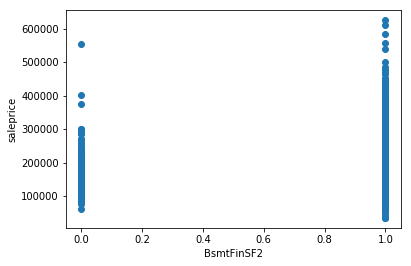

In [100]:
# flagging the feature

train['BsmtFinSF2'] = train['BsmtFinSF2']==0
test['BsmtFinSF2'] = test['BsmtFinSF2']==0
scatter_plot('BsmtFinSF2')

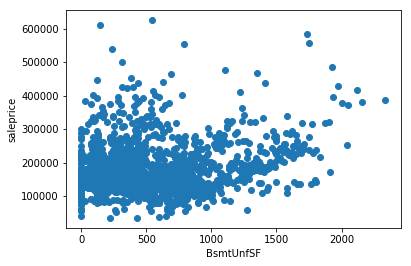

In [101]:
scatter_plot('BsmtUnfSF')

In [102]:
create_bins('BsmtUnfSF', 3)
train.shape, test.shape

((1456, 89), (1459, 88))

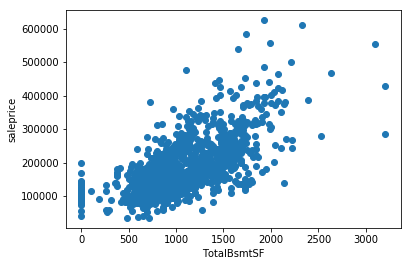

In [103]:
scatter_plot('TotalBsmtSF')

In [104]:
# seems high corelated, so deviding into more bins

create_bins('TotalBsmtSF', 8)
train.shape, test.shape

((1456, 96), (1459, 95))

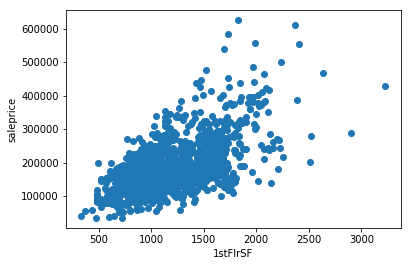

In [105]:
scatter_plot('1stFlrSF')

In [106]:
create_bins('1stFlrSF', 6)
train.shape, test.shape

((1456, 101), (1459, 100))

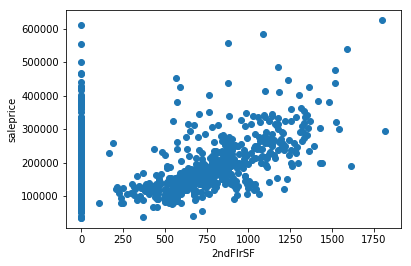

In [107]:
scatter_plot('2ndFlrSF')

In [108]:
create_bins('2ndFlrSF', 6)
train.shape, test.shape

((1456, 106), (1459, 105))

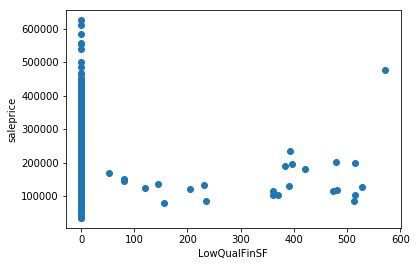

In [109]:
scatter_plot('LowQualFinSF')

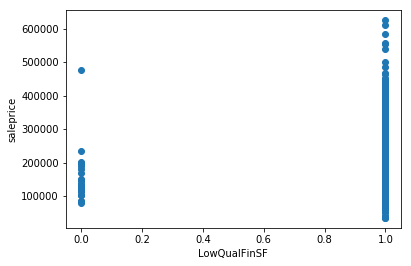

In [110]:
# does not seem corelated

train['LowQualFinSF'] = train['LowQualFinSF']==0
test['LowQualFinSF'] = test['LowQualFinSF']==0
scatter_plot('LowQualFinSF')

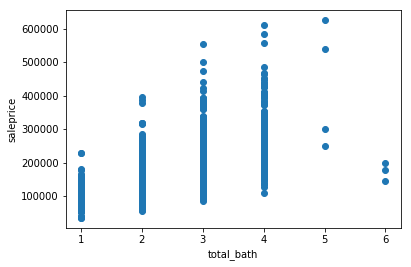

In [111]:
train['total_bath'] = train['BsmtHalfBath'] + train['BsmtFullBath'] + train['HalfBath'] + train['FullBath']
test['total_bath'] = test['BsmtHalfBath'] + test['BsmtFullBath'] + test['HalfBath'] + test['FullBath']

scatter_plot('total_bath')

In [112]:
drop(['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath'])
train.shape, test.shape

((1456, 103), (1459, 102))

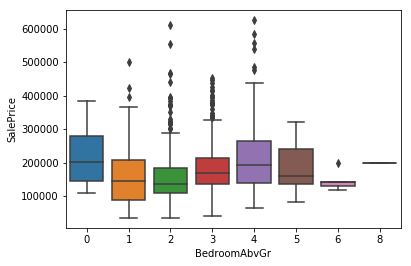

In [113]:
sb.boxplot(train['BedroomAbvGr'], train['SalePrice'])     # leave as it is

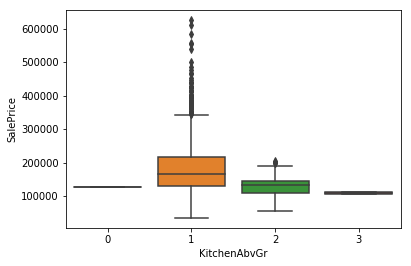

In [114]:
sb.boxplot(train['KitchenAbvGr'], train['SalePrice'])     # leave as it is

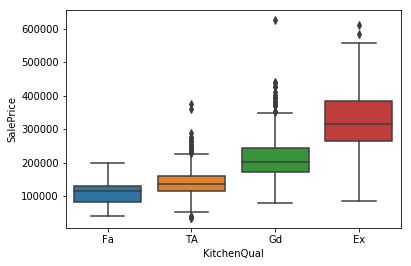

In [115]:
sb.boxplot(train['KitchenQual'], train['SalePrice'], order=['Fa', 'TA', 'Gd', 'Ex'])

In [116]:
train['KitchenQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4], inplace=True)
test['KitchenQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4], inplace=True)
train['KitchenQual'].value_counts()

2    735
3    586
4     96
1     39
Name: KitchenQual, dtype: int64

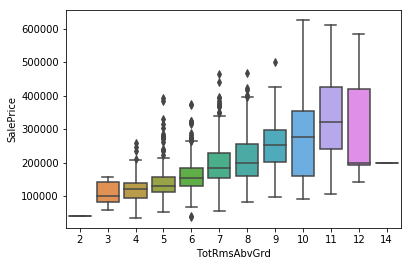

In [117]:
sb.boxplot(train['TotRmsAbvGrd'], train['SalePrice'])         # leave as it is

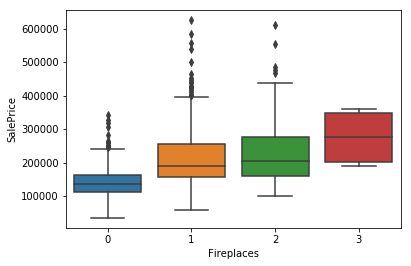

In [118]:
sb.boxplot(train['Fireplaces'], train['SalePrice'])         # leave as it is

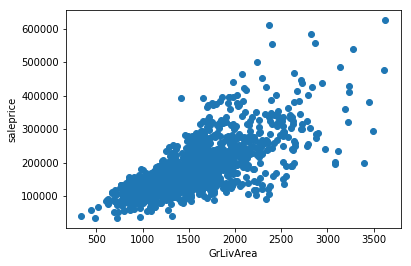

In [119]:
scatter_plot('GrLivArea')

In [120]:
create_bins('GrLivArea', 6)
train.shape, test.shape

((1456, 108), (1459, 107))

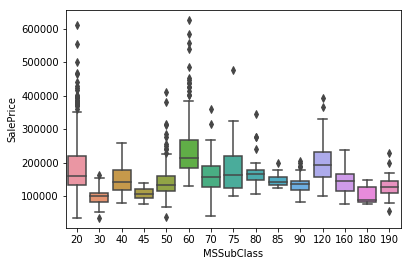

In [121]:
sb.boxplot(train['MSSubClass'], train['SalePrice'])

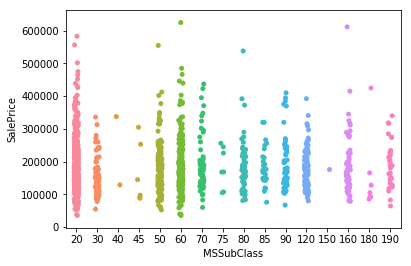

In [122]:
sb.stripplot(test['MSSubClass'], train['SalePrice'], jitter=True)

In [123]:
make_dummies('MSSubClass')
train.shape, test.shape

((1456, 122), (1459, 122))

In [124]:
test.drop(['MSSubClass_150'], axis=1, inplace=True)
train.shape, test.shape

((1456, 122), (1459, 121))

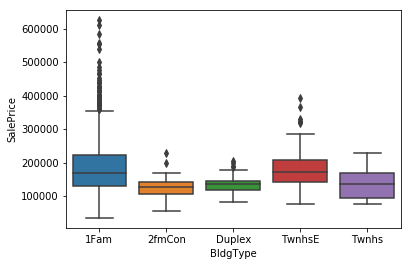

In [125]:
sb.boxplot(train['BldgType'], train['SalePrice'])

In [126]:
make_dummies('BldgType')
train.shape, test.shape

((1456, 126), (1459, 125))

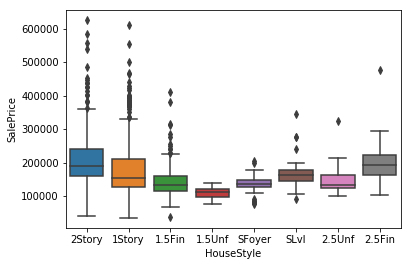

In [127]:
sb.boxplot(train['HouseStyle'], train['SalePrice'])

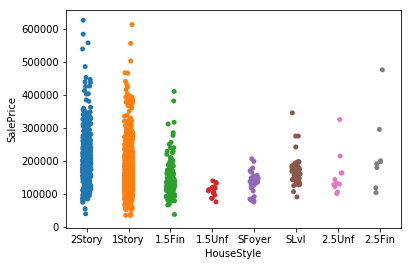

In [128]:
sb.stripplot(train['HouseStyle'], train['SalePrice'], jitter=True)

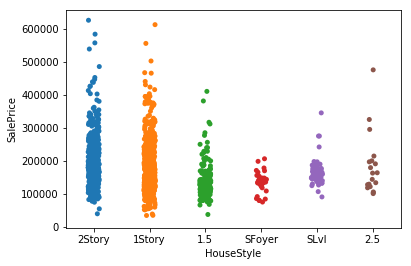

In [129]:
train['HouseStyle'].replace(['1.5Unf', '1.5Fin', '2.5Fin', '2.5Unf'],['1.5','1.5','2.5', '2.5'], inplace=True)
test['HouseStyle'].replace(['1.5Unf', '1.5Fin', '2.5Fin', '2.5Unf'],['1.5','1.5','2.5', '2.5'], inplace=True)
sb.stripplot(train['HouseStyle'], train['SalePrice'], jitter=True)

In [130]:
make_dummies('HouseStyle')
train.shape, test.shape

((1456, 131), (1459, 130))

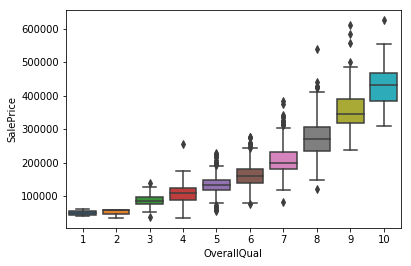

In [131]:
sb.boxplot(train['OverallQual'], train['SalePrice'])        # leave as it is

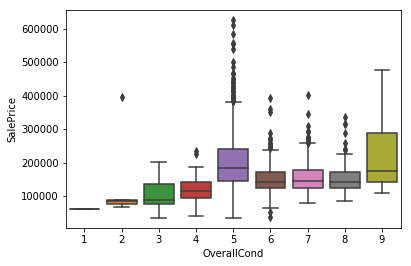

In [132]:
sb.boxplot(train['OverallCond'], train['SalePrice'])        # leave as it is

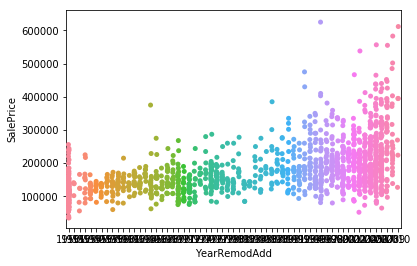

In [133]:
sb.stripplot(train['YearRemodAdd'], train['SalePrice'], jitter=0.1)

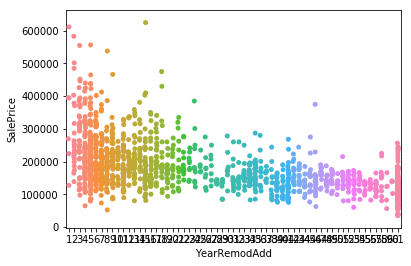

In [134]:
train['YearRemodAdd'] = 2011-train['YearRemodAdd']
test['YearRemodAdd'] = 2011-test['YearRemodAdd']
sb.stripplot(train['YearRemodAdd'], train['SalePrice'], jitter=0.1)

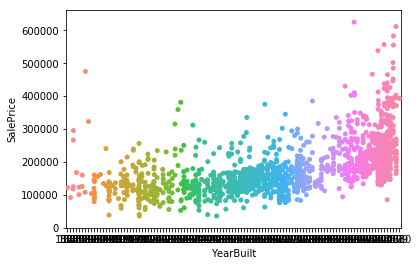

In [135]:
sb.stripplot(train['YearBuilt'], train['SalePrice'], jitter=0.1)

In [136]:
create_bins('YearBuilt', 7)
train.shape, test.shape

((1456, 137), (1459, 136))

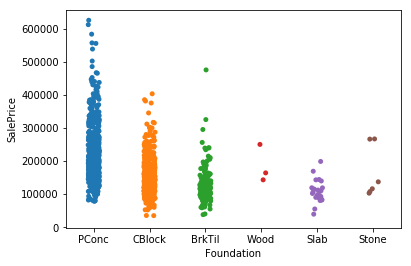

In [137]:
sb.stripplot(train['Foundation'], train['SalePrice'], jitter=0.1)

In [138]:
make_dummies('Foundation')
train.shape, test.shape

((1456, 142), (1459, 141))

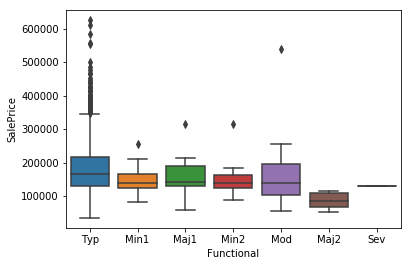

In [139]:
sb.boxplot(train['Functional'], train['SalePrice']) 

In [140]:
train['Functional'].value_counts()

Typ     1356
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [141]:
train['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev'],
                            [6, 5, 4, 3, 2, 1, 1], inplace=True)
test['Functional'].replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev'],
                            [6, 5, 4, 3, 2, 1, 1], inplace=True)
train['Functional'].value_counts()

6    1356
4      34
5      31
3      15
2      14
1       6
Name: Functional, dtype: int64

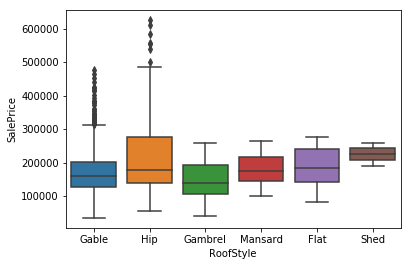

In [142]:
sb.boxplot(train['RoofStyle'], train['SalePrice']) 

In [143]:
make_dummies('RoofStyle')
train.shape, test.shape

((1456, 147), (1459, 146))

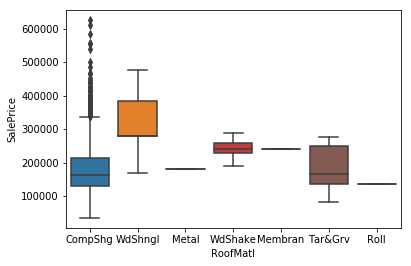

In [144]:
sb.boxplot(train['RoofMatl'], train['SalePrice']) 

In [145]:
train['RoofMatl'].value_counts()

CompShg    1432
Tar&Grv      11
WdShake       5
WdShngl       5
Membran       1
Roll          1
Metal         1
Name: RoofMatl, dtype: int64

In [146]:
test['RoofMatl'].value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

In [147]:
make_dummies('RoofMatl')
train.shape, test.shape

((1456, 153), (1459, 149))

In [148]:
train.drop(['RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll'], axis=1, inplace=True)
train.shape, test.shape

((1456, 150), (1459, 149))

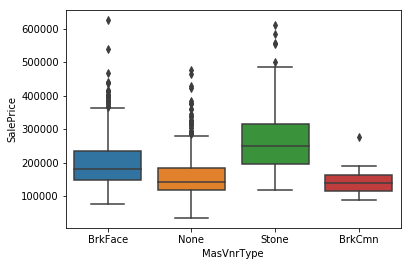

In [149]:
sb.boxplot(train['MasVnrType'], train['SalePrice']) 

In [150]:
make_dummies('MasVnrType')
train.shape, test.shape

((1456, 153), (1459, 152))

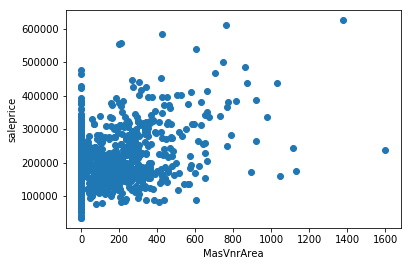

In [151]:
scatter_plot('MasVnrArea')

In [152]:
drop('MasVnrArea')
train.shape, test.shape

((1456, 152), (1459, 151))

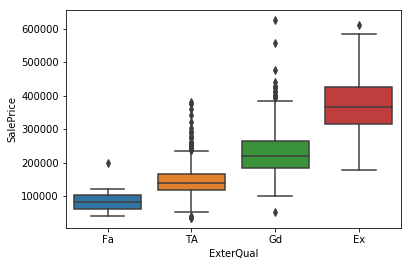

In [153]:
sb.boxplot(train['ExterQual'], train['SalePrice'], order=['Fa', 'TA', 'Gd', 'Ex']) 

In [154]:
train['ExterQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1, 2, 3, 4], inplace=True)
test['ExterQual'].replace(['Fa', 'TA', 'Gd', 'Ex'],[1, 2, 3, 4], inplace=True)

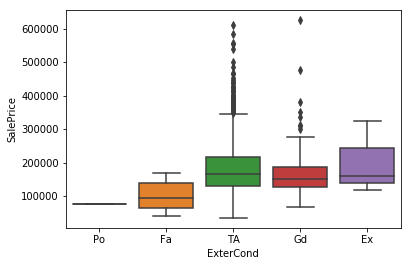

In [155]:
sb.boxplot(train['ExterCond'], train['SalePrice'], order=['Po', 'Fa', 'TA', 'Gd', 'Ex']) 

In [156]:
make_dummies('ExterCond')
train.shape, test.shape

((1456, 156), (1459, 155))

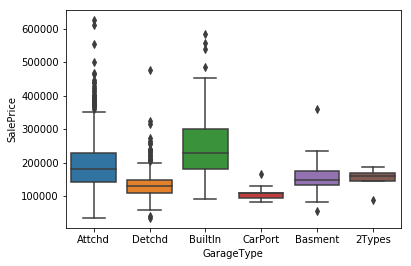

In [157]:
sb.boxplot(train['GarageType'], train['SalePrice']) 

In [158]:
make_dummies('GarageType')
train.shape, test.shape

((1456, 161), (1459, 160))

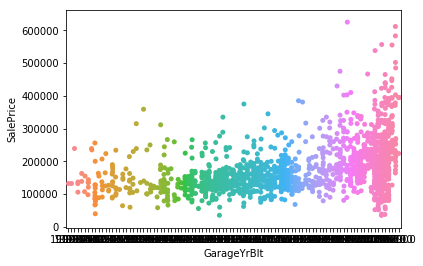

In [159]:
sb.stripplot(train['GarageYrBlt'], train['SalePrice'], jitter=0.1)

In [160]:
create_bins('GarageYrBlt', 3)
train.shape, test.shape

((1456, 163), (1459, 162))

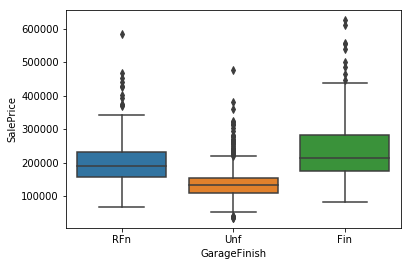

In [161]:
sb.boxplot(train['GarageFinish'], train['SalePrice']) 

In [162]:
make_dummies('GarageFinish')
train.shape, test.shape

((1456, 165), (1459, 164))

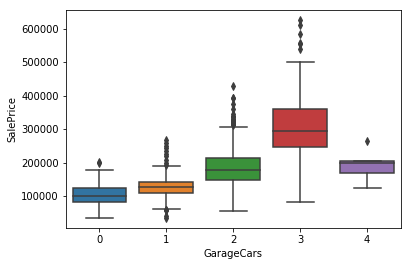

In [163]:
sb.boxplot(train['GarageCars'], train['SalePrice'])      # leave as it is

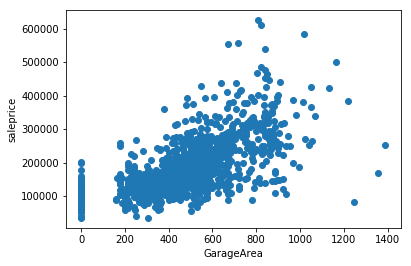

In [164]:
scatter_plot('GarageArea')

In [165]:
create_bins('GarageArea', 3)
train.shape, test.shape

((1456, 167), (1459, 166))

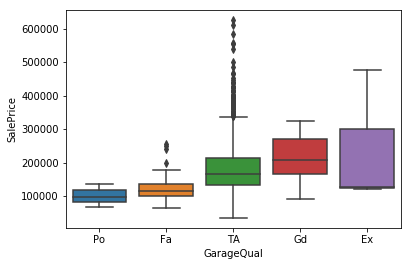

In [166]:
sb.boxplot(train['GarageQual'], train['SalePrice'], order=['Po','Fa','TA','Gd','Ex'])

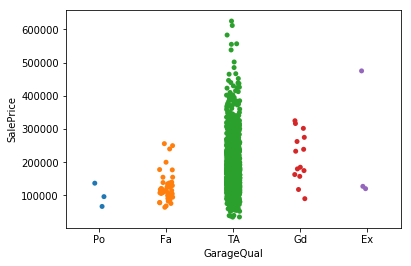

In [167]:
sb.stripplot(train['GarageQual'], train['SalePrice'], jitter=True, order=['Po','Fa','TA','Gd','Ex'])

In [168]:
train['GarageQual'].replace(['Ex', 'Po'],['Gd','Fa'], inplace=True)
test['GarageQual'].replace(['Ex', 'Po'],['Gd','Fa'], inplace=True)
train['GarageQual'].value_counts()

TA    1388
Fa      51
Gd      17
Name: GarageQual, dtype: int64

In [169]:
make_dummies('GarageQual')
train.shape, test.shape

((1456, 169), (1459, 168))

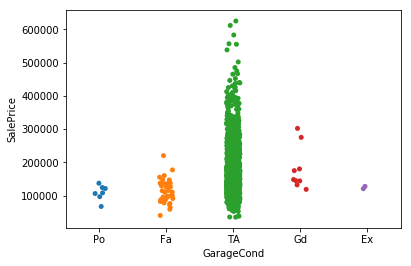

In [170]:
sb.stripplot(train['GarageCond'], train['SalePrice'], jitter=True, order=['Po','Fa','TA','Gd','Ex'])

In [171]:
train['GarageCond'].replace(['Ex', 'Po'],['Gd','Fa'], inplace=True)
test['GarageCond'].replace(['Ex', 'Po'],['Gd','Fa'], inplace=True)
train['GarageCond'].value_counts()

TA    1403
Fa      42
Gd      11
Name: GarageCond, dtype: int64

In [172]:
make_dummies('GarageCond')
train.shape, test.shape

((1456, 171), (1459, 170))

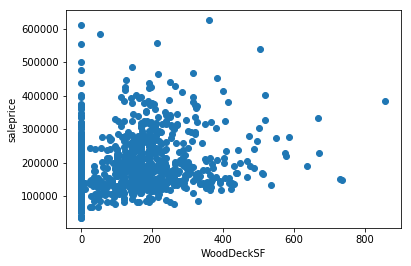

In [173]:
scatter_plot('WoodDeckSF')

In [174]:
train['HasWoodDeck'] = train['WoodDeckSF']==0
test['HasWoodDeck'] = test['WoodDeckSF']==0
train.shape, test.shape

((1456, 172), (1459, 171))

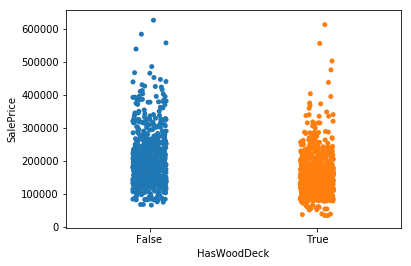

In [175]:
sb.stripplot(train['HasWoodDeck'], train['SalePrice'], jitter=True)

In [176]:
create_bins('WoodDeckSF', 4)
train.shape, test.shape

((1456, 175), (1459, 174))

In [177]:
train['total_porch'] = train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
test['total_porch'] = test['OpenPorchSF']+test['EnclosedPorch']+test['3SsnPorch']+test['ScreenPorch']

drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'])

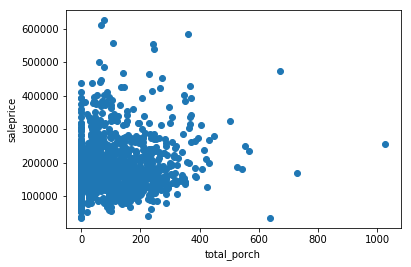

In [178]:
scatter_plot('total_porch')

In [179]:
create_bins('total_porch', 4)
train.shape, test.shape

((1456, 175), (1459, 174))

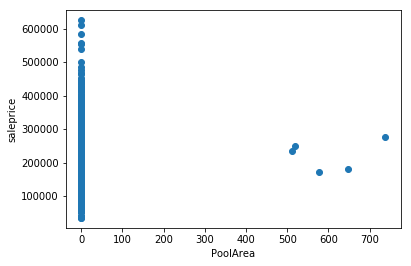

In [180]:
scatter_plot('PoolArea')

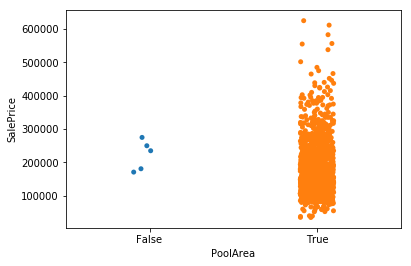

In [181]:
train['PoolArea'] = train['PoolArea']==0
test['PoolArea'] = test['PoolArea']==0
sb.stripplot(train['PoolArea'], train['SalePrice'], jitter=True)

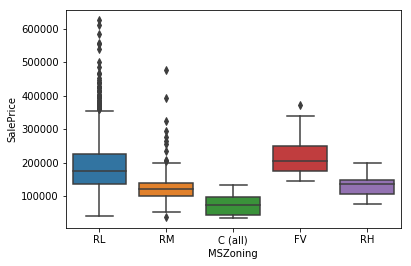

In [182]:
sb.boxplot(train['MSZoning'], train['SalePrice'])

In [183]:
make_dummies('MSZoning')
train.shape, test.shape

((1456, 179), (1459, 178))

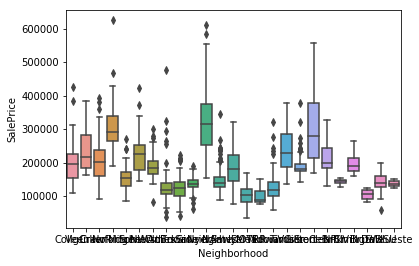

In [184]:
sb.boxplot(train['Neighborhood'], train['SalePrice'])

In [185]:
make_dummies('Neighborhood')
train.shape, test.shape

((1456, 203), (1459, 202))

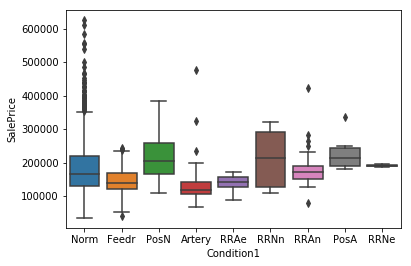

In [186]:
sb.boxplot(train['Condition1'], train['SalePrice'])

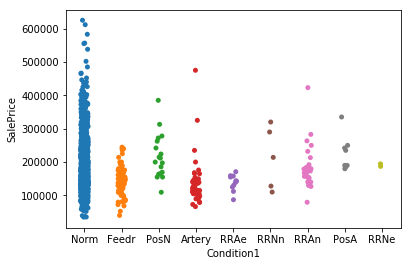

In [187]:
sb.stripplot(train['Condition1'], train['SalePrice'], jitter=True,)

In [188]:
make_dummies('Condition1')
train.shape, test.shape

((1456, 211), (1459, 210))

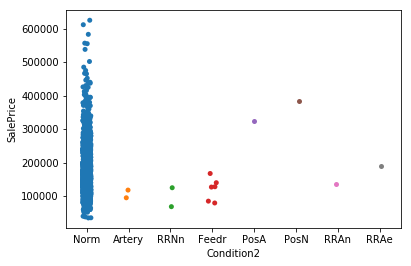

In [189]:
sb.stripplot(train['Condition2'], train['SalePrice'], jitter=True,)

In [190]:
drop('Condition2')
train.shape, test.shape

((1456, 210), (1459, 209))

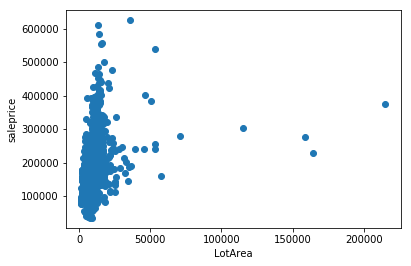

In [191]:
scatter_plot('LotArea')

In [192]:
create_bins('LotArea', [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,100000,200000])
train.shape, test.shape

((1456, 221), (1459, 220))

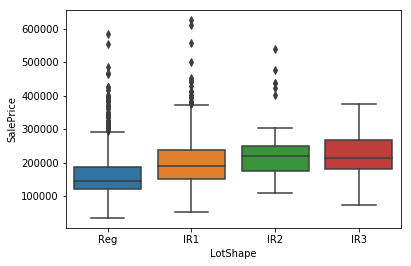

In [193]:
sb.boxplot(train['LotShape'], train['SalePrice'])

In [194]:
# does not seem corelated

make_dummies('LotShape')
train.shape, test.shape

((1456, 224), (1459, 223))

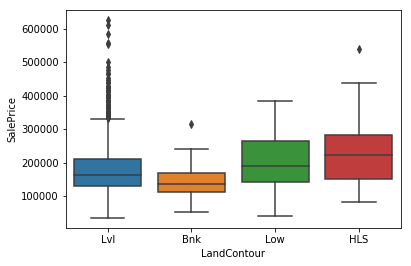

In [195]:
sb.boxplot(train['LandContour'], train['SalePrice'])

In [196]:
make_dummies('LandContour')
train.shape, test.shape

((1456, 227), (1459, 226))

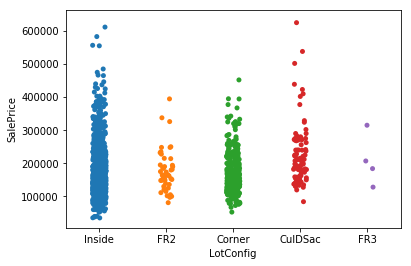

In [197]:
sb.stripplot(train['LotConfig'], train['SalePrice'], jitter=True,)

In [198]:
# clustering fr2 and fr3

train['LotConfig'].replace(['FR2'],['FR3'], inplace=True)
test['LotConfig'].replace(['FR2'],['FR3'], inplace=True)
train['LotConfig'].value_counts()

Inside     1051
Corner      260
CulDSac      94
FR3          51
Name: LotConfig, dtype: int64

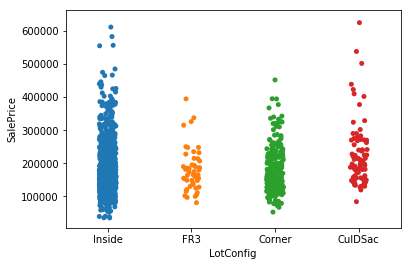

In [199]:
sb.stripplot(train['LotConfig'], train['SalePrice'], jitter=True,)

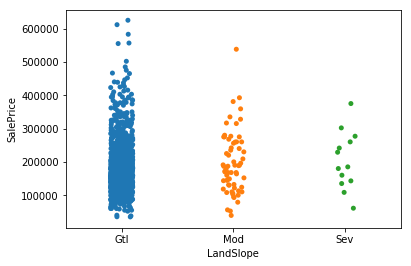

In [200]:
sb.stripplot(train['LandSlope'], train['SalePrice'], jitter=True,)

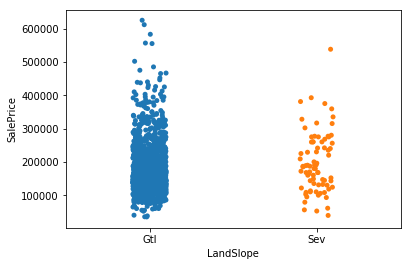

In [201]:
train['LandSlope'].replace(['Mod'],['Sev'], inplace=True)
test['LandSlope'].replace(['Mod'],['Sev'], inplace=True)
sb.stripplot(train['LandSlope'], train['SalePrice'], jitter=True,)

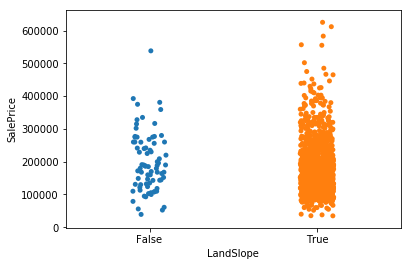

In [202]:
train['LandSlope'] = train['LandSlope'] == 'Gtl'
test['LandSlope'] = test['LandSlope'] == 'Gtl'
sb.stripplot(train['LandSlope'], train['SalePrice'], jitter=True,)

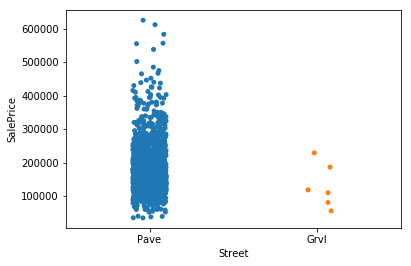

In [203]:
sb.stripplot(train['Street'], train['SalePrice'], jitter=True,)

In [204]:

drop('Street')
train.shape, test.shape

((1456, 226), (1459, 225))

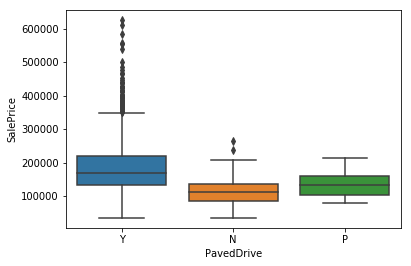

In [205]:
sb.boxplot(train['PavedDrive'], train['SalePrice'])

In [206]:
make_dummies('PavedDrive')
train.shape, test.shape

((1456, 228), (1459, 227))

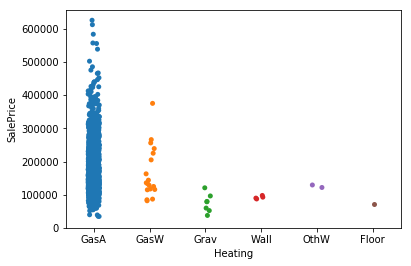

In [207]:
sb.stripplot(train['Heating'], train['SalePrice'], jitter=True,)

In [208]:
# if house have GasA the true else false

train['Heating'] = train['Heating']=='GasA'
test['Heating'] = test['Heating']=='GasA'

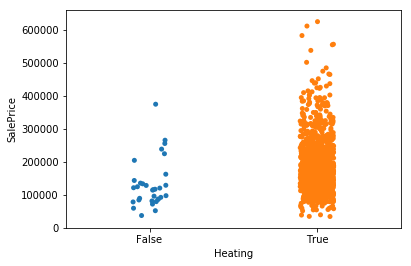

In [209]:
sb.stripplot(train['Heating'], train['SalePrice'], jitter=True,)

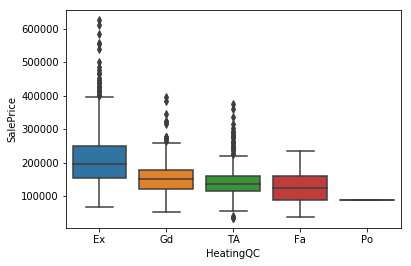

In [210]:
sb.boxplot(train['HeatingQC'], train['SalePrice'])

In [211]:
train['HeatingQC'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4,5], inplace=True)
test['HeatingQC'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'],[1,2,3,4,5], inplace=True)
train.shape, test.shape

((1456, 228), (1459, 227))

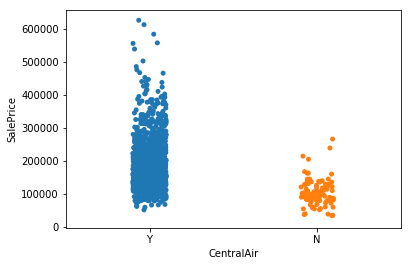

In [212]:
sb.stripplot(train['CentralAir'], train['SalePrice'], jitter=True,)

In [213]:
train['CentralAir'].replace(['Y', 'N'],[1,0], inplace=True)
test['CentralAir'].replace(['Y', 'N'],[1,0], inplace=True)
train['CentralAir'].value_counts()

1    1361
0      95
Name: CentralAir, dtype: int64

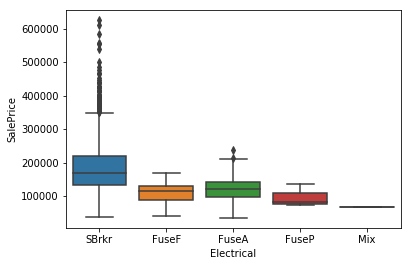

In [214]:
sb.boxplot(train['Electrical'], train['SalePrice'])

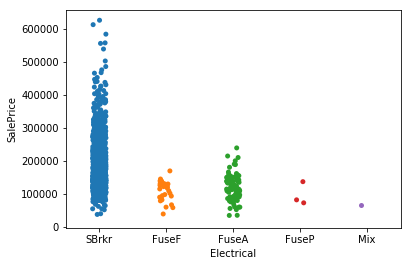

In [215]:
sb.stripplot(train['Electrical'], train['SalePrice'], jitter=True,)

In [216]:
# clustering all Fuse points

train['Electrical'].replace(['FuseF', 'FuseA', 'FuseP'],'Fuse', inplace=True)
test['Electrical'].replace(['FuseF', 'FuseA', 'FuseP'],'Fuse', inplace=True)

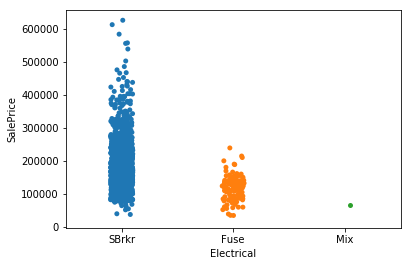

In [217]:
sb.stripplot(train['Electrical'], train['SalePrice'], jitter=True,)

In [218]:
make_dummies('Electrical')

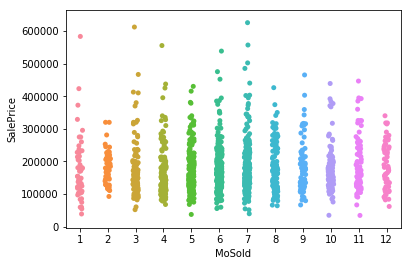

In [219]:
sb.stripplot(train['MoSold'], train['SalePrice'], jitter=True,)

In [220]:
make_dummies('MoSold')
train.shape, test.shape

((1456, 241), (1459, 239))

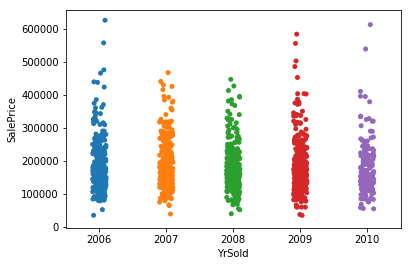

In [221]:
sb.stripplot(train['YrSold'], train['SalePrice'], jitter=True)

In [222]:
make_dummies('YrSold')
train.shape, test.shape

((1456, 245), (1459, 243))

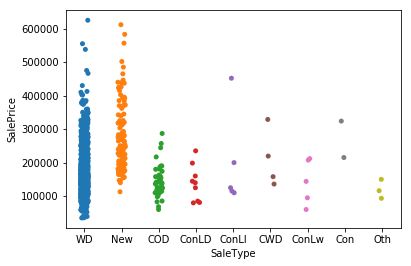

In [223]:
sb.stripplot(train['SaleType'], train['SalePrice'], jitter=True)

In [224]:
train['SaleType'].value_counts()

WD       1265
New       120
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [225]:
train['SaleType'].replace(['ConLD', 'ConLw', 'ConLI', 'CWD', 'Oth', 'Con'],'Con', inplace=True)
test['SaleType'].replace(['ConLD', 'ConLw', 'ConLI', 'CWD', 'Oth', 'Con'],'Con', inplace=True)

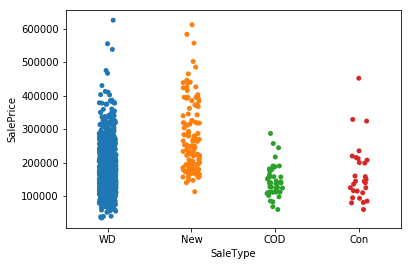

In [226]:
sb.stripplot(train['SaleType'], train['SalePrice'], jitter=True)

In [227]:
make_dummies('SaleType')

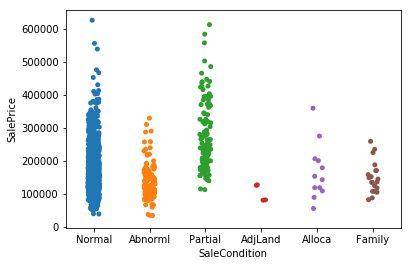

In [228]:
sb.stripplot(train['SaleCondition'], train['SalePrice'], jitter=True)

In [229]:
make_dummies('SaleCondition')
train.shape, test.shape

((1456, 253), (1459, 251))

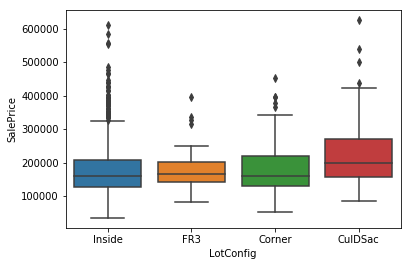

In [230]:
sb.boxplot(train['LotConfig'], train['SalePrice'])

In [231]:
make_dummies('LotConfig')
train.shape, test.shape

((1456, 256), (1459, 254))

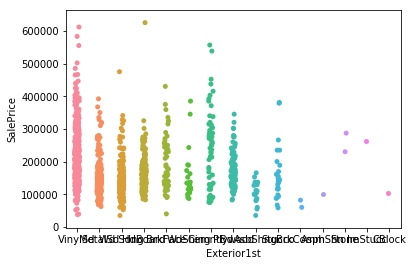

In [232]:
sb.stripplot(train['Exterior1st'], train['SalePrice'], jitter=True)

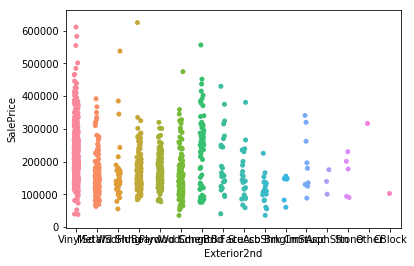

In [233]:
sb.stripplot(train['Exterior2nd'], train['SalePrice'], jitter=True)

In [234]:
make_dummies('Exterior1st')
make_dummies('Exterior2nd')

In [235]:
train.shape, test.shape

((1456, 285), (1459, 280))

In [236]:
for i in train.columns:
    if i not in test.columns:
        print(i)

SalePrice
Electrical_Mix
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other


In [237]:
train.drop(['Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Electrical_Mix'], axis=1, inplace=True)
train.shape, test.shape

((1456, 281), (1459, 280))

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


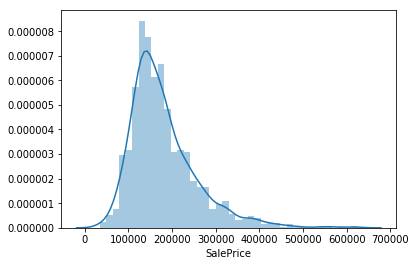

In [238]:
sb.distplot(train['SalePrice'], kde=True, rug=False);

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


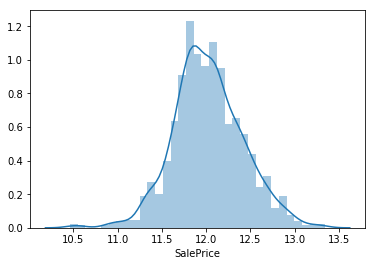

In [239]:
sb.distplot(np.log(train['SalePrice']), kde=True, rug=False);

In [240]:
train.shape, test.shape

((1456, 281), (1459, 280))

In [241]:
out = open('data/train.pickle', 'wb')
pk.dump(train, out)
out = open('data/test.pickle', 'wb')
pk.dump(test, out)
out.close()

In [242]:
out = open('data/train.pickle', 'rb')
features = pk.load(out)
out = open('data/test.pickle', 'rb')
my_test = pk.load(out)
out.close()

In [243]:
labels = features['SalePrice']
features.drop('SalePrice', axis=1, inplace=True)
features.drop('Id', axis=1, inplace=True)
index = my_test['Id']
my_test.drop('Id', axis=1, inplace=True)

In [244]:
model = xg.XGBRegressor()
model.fit(features, labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [245]:
feat_imp = dict()
for i in range(len(features.columns)):
    feat_imp[features.columns[i]] = model.feature_importances_[i]
    
sort = sorted(feat_imp.items(), key=operator.itemgetter(1))    
columns_to_keep = sort[-70:]

In [246]:
important_features = list()
for i in columns_to_keep:
    important_features.append(i[0])
important_features = list(reversed(important_features))    

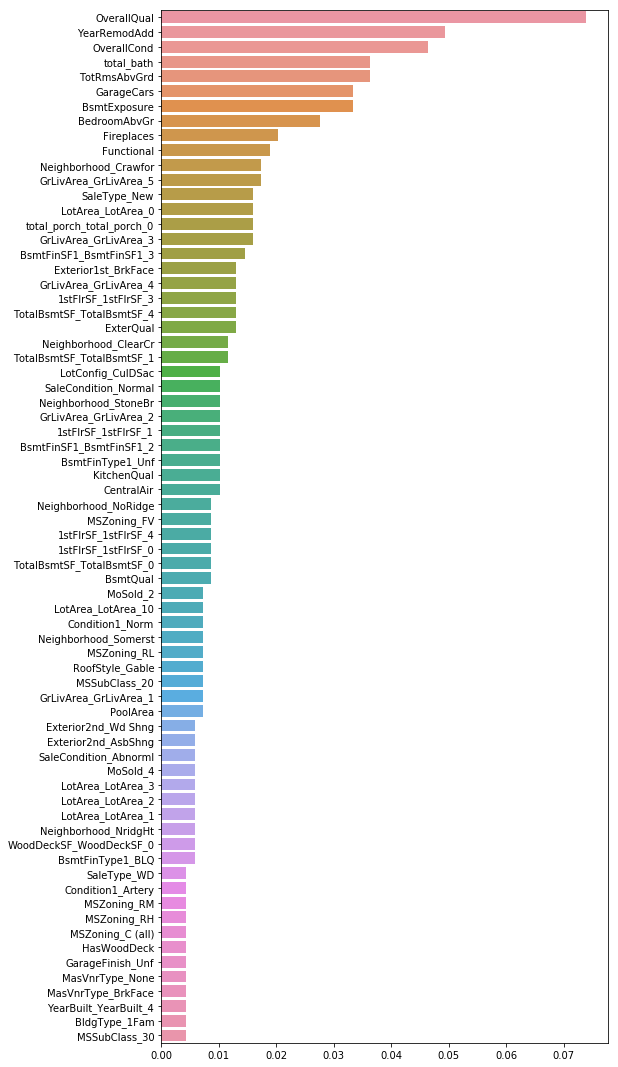

In [247]:
score = []
for i in (important_features):
    score.append(feat_imp[i])
    
fig, ax = plt.subplots(figsize=(8,19))
sb.barplot(score, (important_features), orient='h', ax=ax)

In [248]:
features_to_drop = list()
for i in features.columns:
    if i not in important_features:
        features_to_drop.append(i)
len(features_to_drop), len(important_features)        

(209, 70)

In [249]:
features.drop(features_to_drop, axis=1, inplace=True)
my_test.drop(features_to_drop, axis=1, inplace=True)

In [250]:
out = open('data/features.pickle', 'wb')
pk.dump(features, out)
out = open('data/labels.pickle', 'wb')
pk.dump(labels, out)
out = open('data/test.pickle', 'wb')
pk.dump(my_test, out)
out.close()